# Determination des période de maintenance



# Sommaire:


- **1. Importation des librairies**
- **2. Datasets Commandes et clients** 
- **3. Pipeline de modelisation**
- **4. Datasets d'entrainement et de prédictions**
- **5. Détermination de la période de maintenance**


***

# 1. Importation des librairies

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# 2. Datasets Commandes et clients

In [107]:
# Importation des données
# Importation des données
customers_df = pd.read_csv('olist_customers_dataset.csv', usecols=['customer_id',
                                                                   'customer_unique_id',
                                                                   'customer_state'])
orders_df = pd.read_csv('olist_orders_dataset.csv', usecols=['order_id',
                                                             'customer_id',
                                                             'order_status',
                                                             'order_purchase_timestamp',
                                                             'order_approved_at',
                                                             'order_delivered_customer_date',
                                                             'order_estimated_delivery_date'])
order_items_df = pd.read_csv('olist_order_items_dataset.csv', usecols=['order_id',
                                                                       'price',
                                                                       'product_id',
                                                                       'order_item_id'])
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv', usecols=['order_id',
                                                                           'review_score'])
order_payments_df = pd.read_csv('olist_order_payments_dataset.csv', usecols=['order_id',
                                                                             'payment_type',
                                                                             'payment_value'])

- ### Joindre les datasets

In [108]:
# Jointure des données
merge1 = [orders_df, order_items_df, order_reviews_df]
merge2 = reduce(lambda left, right: pd.merge(
    left, right, on='order_id', how='outer'), merge1)
merge2 = pd.merge(merge2, customers_df, on='customer_id', how='outer')

# Filtre des commandes annulées
merge2 = merge2[(merge2.order_status != 'canceled') &
                (merge2.order_status != 'unavailable')]

# Mise au format Datetime des colonnes de dates
date_variables = ['order_approved_at',
                  'order_delivered_customer_date',
                  'order_estimated_delivery_date']

for i in date_variables:
    merge2[i] = pd.to_datetime(merge2[i], errors='coerce').dt.normalize()

# Création d'une colonne temps de livraison
merge2['temps_de_livraison'] = (
    merge2['order_delivered_customer_date'] - merge2['order_approved_at']).dt.days

# Pour certaines valeurs, le temps de livraison est négatif
merge2['temps_de_livraison'] = np.where(
    merge2['temps_de_livraison'] < 0, 0, merge2['temps_de_livraison'])

- ### Datasets Commandes et clients

In [109]:
# Création du jeu de données par clients et par commande
df_clients_et_commandes = merge2[['temps_de_livraison',
                                  'customer_unique_id',
                                  'price',
                                  'product_id',
                                  'review_score',
                                  'order_id',
                                  'order_approved_at',
                                  'customer_state'
                                  ]]\
    .groupby(['customer_unique_id', 'order_id'])\
    .agg({'temps_de_livraison': 'mean',
          'review_score': 'mean',
          'price': 'mean',
          'order_approved_at': 'max',
          'customer_state': 'max',
          'product_id': 'count'})

df_clients_et_commandes['Sum_tot'] = merge2[['customer_unique_id', 'order_id', 'price']].groupby(
    ['customer_unique_id', 'order_id']).agg('sum')
df_clients_et_commandes = df_clients_et_commandes.reset_index()

- ### Dataset clients

In [110]:
# Création du jeu de données par clients
df_clients = df_clients_et_commandes.groupby('customer_unique_id')\
    .agg({'temps_de_livraison': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_clients.columns = ['temps_de_livraison_moyen',
                      'mean_review_score',
                      'first_order',
                      'total_expanse']

# Date de la dernière commande
df_clients['last_order'] = df_clients_et_commandes.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Récence (date du jour - date du dernier achat)
df_clients['recency'] = (
    df_clients["last_order"].max() - df_clients['last_order']).dt.days

# nombre de commande totale
df_clients['nb_order'] = df_clients_et_commandes.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# nombre moyen d'article par panier
df_clients['mean_nb_item'] = df_clients_et_commandes.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

In [111]:
df_clients_et_commandes.shape

(98207, 9)

In [112]:
df_clients.shape

(94990, 8)

# 3. Pipeline de modélisation

In [113]:
features = ['mean_review_score',
            'nb_order',
            'mean_nb_item']


log_features = ['temps_de_livraison_moyen',
                'total_expanse',
                'recency']

features_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

logfeatures_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("logTransformation", FunctionTransformer(
               lambda value: np.log1p(value))),
           ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("features", features_transformer, features),
        ("log_features", logfeatures_transformer, log_features),
    ]
)

model_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                                 ('kmeans', KMeans(random_state=0, n_clusters=6))
                                 ])

# 4. Création du dataframe de départ

In [114]:
df_clients.head()

,temps_de_livraison_moyen,mean_review_score,first_order,total_expanse,last_order,recency,nb_order,mean_nb_item
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,5.0,2018-05-10,129.90,2018-05-10,116.0,1,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,3.0,4.0,2018-05-07,18.90,2018-05-07,119.0,1,1.0
0000f46a3911fa3c0805444483337064,26.0,3.0,2017-03-10,69.00,2017-03-10,542.0,1,1.0
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,2017-10-12,25.99,2017-10-12,326.0,1,1.0
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,2017-11-14,180.00,2017-11-14,293.0,1,1.0


In [115]:
df_clients_et_commandes.head()

,customer_unique_id,order_id,temps_de_livraison,review_score,price,order_approved_at,customer_state,product_id,Sum_tot
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,6.0,5.0,129.90,2018-05-10,SP,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,3.0,4.0,18.90,2018-05-07,SP,1,18.90
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,26.0,3.0,69.00,2017-03-10,SC,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,20.0,4.0,25.99,2017-10-12,PA,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,13.0,5.0,180.00,2017-11-14,SP,1,180.00


In [116]:
# récupération des indes des clients présents du début à la fin de la periode d'analyse
index_clients_debut_fin = df_clients[df_clients['first_order'] <
                                     df_clients['last_order'].max() - pd.DateOffset(weeks=26)].index

# Création du df pour le calcul de l'ARI
df_ARI = df_clients_et_commandes.loc[df_clients_et_commandes['customer_unique_id'].isin(
    index_clients_debut_fin)].copy()

In [117]:
index_clients_debut_fin

Index(['0000f46a3911fa3c0805444483337064', '0000f6ccb0745a6a4b88665a16c9f078',
       '0004aac84e0df4da2b147fca70cf8255', '00053a61a98854899e70ed204dd4bafe',
       '0005e1862207bf6ccc02e4228effd9a0', '0006fdc98a402fceb4eb0ee528f6a8d4',
       '00082cbe03e478190aadbea78542e933', '000a5ad9c4601d2bbdd9ed765d5213b3',
       '000bfa1d2f1a41876493be685390d6d3', '000c8bdb58a29e7115cfc257230fb21b',
       ...
       'fff3a9369e4b7102fab406a334a678c3', 'fff699c184bcc967d62fa2c6171765f7',
       'fff7219c86179ca6441b8f37823ba3d3', 'fffa431dd3fcdefea4b1777d114144f2',
       'fffb09418989a0dbff854a28163e47c6', 'fffbf87b7a1a6fa8b03f081c5f51a201',
       'fffcf5a5ff07b0908bd4e2dbc735a684', 'fffea47cd6d3cc0a88bd621562a9d061',
       'ffff371b4d645b6ecea244b27531430a', 'ffffd2657e2aad2907e67c3e9daecbeb'],
      dtype='object', name='customer_unique_id', length=57446)

In [118]:
df_ARI.head()

,customer_unique_id,order_id,temps_de_livraison,review_score,price,order_approved_at,customer_state,product_id,Sum_tot
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,26.0,3.0,69.00,2017-03-10,SC,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,20.0,4.0,25.99,2017-10-12,PA,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,13.0,5.0,180.00,2017-11-14,SP,1,180.00
7,00053a61a98854899e70ed204dd4bafe,44e608f2db00c74a1fe329de44416a4e,16.0,1.0,191.00,2018-02-28,PR,2,382.00
8,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,5.0,4.0,135.00,2017-03-04,RJ,1,135.00


In [120]:
# Dataframe date_debut_experience :
date_debut_experience = (df_clients['last_order'].max() -
                         pd.DateOffset(weeks=26)).strftime("%Y-%m-%d")
df_date_commande = df_ARI[df_ARI['order_approved_at'] < date_debut_experience]


df_date_clients = df_date_commande.groupby('customer_unique_id')\
    .agg({'temps_de_livraison': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_date_clients.columns = ['temps_de_livraison_moyen',
                           'mean_review_score',
                           'first_order',
                           'total_expanse']


# Date de la dernière commande
df_date_clients['last_order'] = df_date_commande.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Recency : (date du jour - date du dernier achat)
df_date_clients['recency'] = (
    df_date_clients["last_order"].max() - df_date_clients['last_order']).dt.days

# Nb_order : nombre de commande totale
df_date_clients['nb_order'] = df_date_commande.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# Mean_nb_item : nombre moyen d'article par panier
df_date_clients['mean_nb_item'] = df_date_commande.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

df_t0 = df_date_clients

In [121]:
date_debut_experience

'2018-03-05'

# 5. Détermination de la période de maintenance

In [122]:
# Création du dataframe d'entrainement
entrainement = pd.DataFrame(model_pipeline.fit_predict(df_t0), columns=[date_debut_experience])
# Création du dataframe de prédictions
predictions = pd.DataFrame(model_pipeline.predict(df_t0), columns=[date_debut_experience])

In [123]:
print(len(predictions.columns))

1


In [124]:
date_debut_experience

'2018-03-05'

In [127]:
for week in range(25, -1, -1):
    # sauvegarde du temps de l'export :
    date_debut_experience = (df_clients['last_order'].max(
    ) - pd.DateOffset(weeks=week)).strftime("%Y-%m-%d")

    # création du dataframe contenant toutes les ventes de la première
    # vente à la dernièrevente - semaine :
    df_date_commande = df_ARI[df_ARI['order_approved_at']
                              < date_debut_experience]

    # création du dataframe regroupé par client
    df_date_clients = df_date_commande.groupby('customer_unique_id')\
        .agg({'temps_de_livraison': 'mean',
              'review_score': 'mean',
              'order_approved_at': 'min',
              'Sum_tot': 'sum'}).round(2)

    df_date_clients.columns = ['temps_de_livraison_moyen',
                               'mean_review_score',
                               'first_order',
                               'total_expanse']

    # Date de la dernière commande
    df_date_clients['last_order'] = df_date_commande.groupby(
        'customer_unique_id').agg({'order_approved_at': 'max'})

    # Recency : (date du jour - date du dernier achat)
    df_date_clients['recency'] = (
        df_date_clients["last_order"].max() - df_date_clients['last_order']).dt.days

    # Nb_order : nombre de commande totale
    df_date_clients['nb_order'] = df_date_commande.groupby(
        'customer_unique_id').agg({'order_id': 'count'})

    # Mean_nb_item : nombre moyen d'article par panier
    df_date_clients['mean_nb_item'] = df_date_commande.groupby(
        'customer_unique_id').agg({'product_id': 'mean'}).round(2)

    # Entrainement du modèle sur le df au temps n et Prédiction des clusters : stablitié des cluster
    entrainement[date_debut_experience] = model_pipeline.fit_predict(
        df_date_clients)
    clusters_weeks[time_export] = model_pipeline.fit_predict(df_temp_customer)
    # Prédiction des clusters du df_tn avec le modèle entrainé en T0 (-26 semaines) : contrat de maintenance
    model_pipeline.fit(df_t0)
    predictions[date_debut_experience] = model_pipeline.predict(
        df_date_clients)

In [128]:
ARI_kmeans = []
ARI_kmeans2 = []


for col in range(0, 26):
    temp = adjusted_rand_score(
        entrainement.iloc[:, col], entrainement.iloc[:, col+1])
    ARI_kmeans.append(temp)

    temp = adjusted_rand_score(
        predictions.iloc[:, 0], predictions.iloc[:, col])
    ARI_kmeans2.append(temp)


stability = pd.DataFrame(ARI_kmeans, columns=["ARI"])
stability['date'] = list(entrainement.columns)[:-1]


maintenance = pd.DataFrame(ARI_kmeans2, columns=["ARI"])
maintenance['date'] = list(predictions.columns)[:-1]

In [129]:
# Créer un dataframe pour ARI_kmeans_stability
maintenance_df = pd.DataFrame(
    {'Date': predictions.columns[:-1], 'Score ARI': ARI_kmeans2})
# Trier le dataframe par date
ARI_df = maintenance_df.sort_values(by='Date')
# Réinitialiser l'index
ARI_df = ARI_df.reset_index(drop=True)
ARI_df = pd.DataFrame(ARI_df)
ARI_df

,Date,Score ARI
0,2018-03-05,1.000000
1,2018-03-12,0.944112
2,2018-03-19,0.896501
3,2018-03-26,0.856869
4,2018-04-02,0.823673
5,2018-04-09,0.796754
6,2018-04-16,0.774485
7,2018-04-23,0.763656
8,2018-04-30,0.750184
9,2018-05-07,0.743029


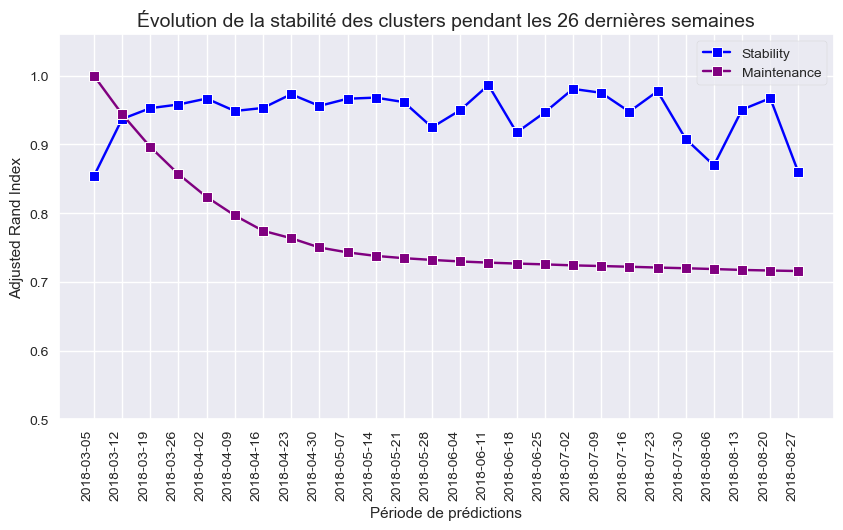

In [130]:
plt.figure(figsize=(10, 5), dpi=100)
sns.set_style('darkgrid')
sns.lineplot(data=stability, x='date', y='ARI',
             marker="s", color='blue', label='Stability')
sns.lineplot(data=maintenance, x='date', y='ARI',
             marker="s", color='purple', label='Maintenance')
plt.xlabel("Période de prédictions")
plt.xticks(rotation=90, ha='right')
plt.ylabel("Adjusted Rand Index")
plt.title("Évolution de la stabilité des clusters pendant les 26 dernières semaines", fontsize=14)
plt.legend(frameon=True)
plt.ylim(0.5, 1.06)
plt.show()

### **Remarques**
- La courbe de maintenance (scores ARI) du modèle de segmentation commence à 1 et décroît sur les 12 premiere semaines pour se stabiliser à 0.7 sur la période restante. Cela signifie que notre modèle a bien fonctionné initialement mais qu'il est maintenant devenu moins performant.
- La qualité de la segmentation est moins stable sur des données que le modèle n'a jamais vu auparavant.
- Nous recommandons donc la réévaluation de l'algorithme pour trouver la meilleure configuration.


In [1]:
pip install autopep8

Note: you may need to restart the kernel to use updated packages.
